In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split as split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, pairwise_distances
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
import datetime 
import warnings
from sklearn.datasets import load_iris
from sklearn import svm
from sklearn.metrics import roc_curve, roc_auc_score




# Uploading data

In [3]:
df = pd.read_csv("Df_invoices.csv")
df.head()

,Document Number,Name,Date,Invoice Sent Date,Due Date,Payment Date,Terms,Paying Transaction,Amount Remaining,Amount,Days Overdue,Expected PTP,Location,Date Closed,Contingent Due Date,PO Required,Last Collection Notice Sent
0,095279,7897,6/27/2019,5/23/2019,9/25/2019,NaN,Net 90,,406603.722,406603.722,0.0,9/30/2019,EMEA : Italy,NaN,No,No,NaN
1,091764,7206,2/18/2019,1/15/2019,6/30/2019,NaN,Net 132,,189000.000,189000.000,86.0,NaN,Asia Pacific : South Korea,NaN,No,No,2nd Past Due Notice
2,092603,7743,3/31/2019,2/12/2019,5/15/2019,NaN,Net 45,,166286.116,166286.116,132.0,NaN,EMEA : France,NaN,No,No,1st Past Due Notice
3,095285,7797,6/25/2019,5/8/2019,7/25/2019,NaN,Net 30,,159338.534,159338.534,61.0,NaN,EMEA : Austria,NaN,No,No,Disruption Notice
4,093141,7206,2/12/2019,2/28/2019,6/25/2019,7/31/2019,Net 133,Credit Memo #004641,152000.000,156000.000,91.0,NaN,Asia Pacific : South Korea,NaN,No,No,2nd Past Due Notice


In [4]:
#Let's see dtype and nunlls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30182 entries, 0 to 30181
Data columns (total 17 columns):
Document Number                30182 non-null object
Name                           30182 non-null object
Date                           30182 non-null object
Invoice Sent Date              19384 non-null object
Due Date                       30180 non-null object
Payment Date                   29903 non-null object
Terms                          30021 non-null object
Paying Transaction             30182 non-null object
Amount Remaining               30182 non-null float64
Amount                         30182 non-null float64
Days Overdue                   30180 non-null float64
Expected PTP                   6398 non-null object
Location                       30182 non-null object
Date Closed                    29873 non-null object
Contingent Due Date            30182 non-null object
PO Required                    30182 non-null object
Last Collection Notice Sent    10112 non-

Explanation of  what is every feature uplaoded above:
Document number - Number of the invoice
Payment date -  Date that invoie was paid
Terms - Net days to pay until due date
Paying transaction - ID Number of the payment transaction
Amount Reamining - Amount Remaning to pay
Expected PTP - payment date that client has promised to pay
Location - Location of the customer
Date Closed - Date that invoice was closed in the AR
Contingent Due Date -Yes for invoices with due date contingency
PO Required - Yes for invoices with  Purchase Order req.


# BUILDING OUR TARGET
Target, has the invoice been paid in the first 5 days overdue? 1(Yes) 0 (No)

We need to convert date  columns from str to datatime using datetime library
Date is date of invoice
Payment Date is date that invoice has been paid
Date closed is date that invoice is closed in the system - once payment is posted,not always the same than date of payment


In [5]:
df[["Date","Payment Date","Invoice Sent Date",'Due Date',"Date Closed"]] = df[["Date","Payment Date","Invoice Sent Date",'Due Date',"Date Closed"]].apply(pd.to_datetime)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30182 entries, 0 to 30181
Data columns (total 17 columns):
Document Number                30182 non-null object
Name                           30182 non-null object
Date                           30182 non-null datetime64[ns]
Invoice Sent Date              19384 non-null datetime64[ns]
Due Date                       30180 non-null datetime64[ns]
Payment Date                   29903 non-null datetime64[ns]
Terms                          30021 non-null object
Paying Transaction             30182 non-null object
Amount Remaining               30182 non-null float64
Amount                         30182 non-null float64
Days Overdue                   30180 non-null float64
Expected PTP                   6398 non-null object
Location                       30182 non-null object
Date Closed                    29873 non-null datetime64[ns]
Contingent Due Date            30182 non-null object
PO Required                    30182 non-null object
L

Let's start to calculate our variable that we want to predict. We determinate that value 1 for invoices collected before 
30 days and 0 for those wo were collected above 30 days or werent collected. First we count days between paid date and invoice date

In [7]:
df=df.dropna(subset=['Payment Date'])

In [8]:
df['Days_tobe_paid'] = (df['Payment Date'] - df['Due Date']).dt.days


In [9]:
df['Days_tobe_paid'].median()

15.0

We create new column boolean with TRUE for inv collected before being 15 days overude  and FALSE not collected after being 5 days overdue. After 15 days overdue payment reminders are sent to the client. We would like to put an eye on these invoices on advance to avoid sending these reminders.


In [11]:
df['Target']=df['Days_tobe_paid']<15

In [12]:
df['Target'].value_counts()

False    14961
True     14942
Name: Target, dtype: int64

In [13]:
#We create dummies on column created on cell above
df=pd.get_dummies(df,columns=['Target'],drop_first=True)

In [14]:
#And we have or new df with dummies that are our predict var
df.head()

,Document Number,Name,Date,Invoice Sent Date,Due Date,Payment Date,Terms,Paying Transaction,Amount Remaining,Amount,Days Overdue,Expected PTP,Location,Date Closed,Contingent Due Date,PO Required,Last Collection Notice Sent,Days_tobe_paid,Target_True
4,093141,7206,2019-02-12,2019-02-28,2019-06-25,2019-07-31,Net 133,Credit Memo #004641,152000.000,156000.000,91.0,NaN,Asia Pacific : South Korea,NaT,No,No,2nd Past Due Notice,36,0
11,087922,7422,2018-11-20,2018-10-16,2019-01-19,2019-03-15,Net 60,Payment #61979,78469.177,98646.960,248.0,NaN,EMEA : Denmark,NaT,No,Yes,Portal Lockout,55,0
23,094522,5251:1,2019-05-01,2019-04-11,2019-06-30,2019-07-17,Net 60,Payment #65220,45766.269,120443.907,86.0,NaN,EMEA : France,NaT,No,Yes,2nd Past Due Notice,17,0
24,094522,5251:1,2019-05-01,2019-04-11,2019-06-30,2019-07-17,Net 60,Payment #65220,45766.269,120443.907,86.0,NaN,EMEA : France,NaT,No,Yes,2nd Past Due Notice,17,0
33,095773,7953:1,2019-06-28,2019-05-13,2019-08-27,2019-08-27,Net 60,Payment #66262,28000.000,139600.000,28.0,NaN,Asia Pacific,NaT,No,No,1st Past Due Notice,0,1


In [15]:
df['Target_True'].value_counts()

0    14961
1    14942
Name: Target_True, dtype: int64

More than 15 days (late) is zero
Less than 15 days (soon) is 1

We just want those invoices that were actually paid and not credited. Hence, we just want Payment transactions that were actually payments and no Credit Memo. We proceed to remove credit memos from the df. 

In [16]:

df.rename(columns={'Paying Transaction': 'Paying_Transaction'}, inplace=True)

In [17]:


df['Paying_Transaction'] = df['Paying_Transaction'].apply(lambda x: 'Payment' in x )



In [18]:
df[df['Paying_Transaction']==True]

,Document Number,Name,Date,Invoice Sent Date,Due Date,Payment Date,Terms,Paying_Transaction,Amount Remaining,Amount,Days Overdue,Expected PTP,Location,Date Closed,Contingent Due Date,PO Required,Last Collection Notice Sent,Days_tobe_paid,Target_True
11,087922,7422,2018-11-20,2018-10-16,2019-01-19,2019-03-15,Net 60,True,78469.177,98646.960,248.0,NaN,EMEA : Denmark,NaT,No,Yes,Portal Lockout,55,0
23,094522,5251:1,2019-05-01,2019-04-11,2019-06-30,2019-07-17,Net 60,True,45766.269,120443.907,86.0,NaN,EMEA : France,NaT,No,Yes,2nd Past Due Notice,17,0
24,094522,5251:1,2019-05-01,2019-04-11,2019-06-30,2019-07-17,Net 60,True,45766.269,120443.907,86.0,NaN,EMEA : France,NaT,No,Yes,2nd Past Due Notice,17,0
33,095773,7953:1,2019-06-28,2019-05-13,2019-08-27,2019-08-27,Net 60,True,28000.000,139600.000,28.0,NaN,Asia Pacific,NaT,No,No,1st Past Due Notice,0,1
68,097134,9145,2019-06-28,2019-07-04,2019-09-26,2019-07-30,Net 90,True,12250.000,122400.000,0.0,NaN,North America : Mexico,NaT,No,No,NaN,-58,1
71,IND11000362,6369,2019-06-26,2019-07-23,2019-07-26,2019-08-21,Net 30,True,12216.694,144156.953,60.0,NaN,EMEA : India,NaT,No,Yes,NaN,26,0
73,IND11000362,6369,2019-06-26,2019-07-23,2019-07-26,2019-08-21,Net 30,True,12216.694,144156.953,60.0,NaN,EMEA : India,NaT,No,Yes,NaN,26,0
74,096759,5552,2019-06-02,2019-06-19,2019-07-02,2019-08-26,Net 30,True,12146.770,38462.760,84.0,NaN,North America : Mexico,NaT,No,No,2nd Past Due Notice,55,0
90,095871,5552,2019-06-11,2019-05-21,2019-07-11,2019-07-22,Net 30,True,9739.500,64930.000,75.0,NaN,North America : Mexico,NaT,No,No,2nd Past Due Notice,11,1
104,IND11000339,4642,2018-12-15,2018-12-28,2019-02-13,2019-03-08,Net 60,True,7204.303,27432.056,223.0,NaN,Asia Pacific : India,NaT,No,Yes,NaN,23,0


In [19]:
df.shape

(29903, 19)

In [20]:
#we just want df with paying transaction that are payments
df.query('Paying_Transaction == True', inplace = True) 

In [21]:
df.head()

,Document Number,Name,Date,Invoice Sent Date,Due Date,Payment Date,Terms,Paying_Transaction,Amount Remaining,Amount,Days Overdue,Expected PTP,Location,Date Closed,Contingent Due Date,PO Required,Last Collection Notice Sent,Days_tobe_paid,Target_True
11,087922,7422,2018-11-20,2018-10-16,2019-01-19,2019-03-15,Net 60,True,78469.177,98646.960,248.0,NaN,EMEA : Denmark,NaT,No,Yes,Portal Lockout,55,0
23,094522,5251:1,2019-05-01,2019-04-11,2019-06-30,2019-07-17,Net 60,True,45766.269,120443.907,86.0,NaN,EMEA : France,NaT,No,Yes,2nd Past Due Notice,17,0
24,094522,5251:1,2019-05-01,2019-04-11,2019-06-30,2019-07-17,Net 60,True,45766.269,120443.907,86.0,NaN,EMEA : France,NaT,No,Yes,2nd Past Due Notice,17,0
33,095773,7953:1,2019-06-28,2019-05-13,2019-08-27,2019-08-27,Net 60,True,28000.000,139600.000,28.0,NaN,Asia Pacific,NaT,No,No,1st Past Due Notice,0,1
68,097134,9145,2019-06-28,2019-07-04,2019-09-26,2019-07-30,Net 90,True,12250.000,122400.000,0.0,NaN,North America : Mexico,NaT,No,No,NaN,-58,1


In [22]:
df.shape

(19778, 19)

In [23]:
df['Document Number'].value_counts()

IND11000209    18
IND11000273    17
IND11000317    12
IND11000186    12
060776          9
074132          8
067782          6
067388          6
064625          6
IND11000238     6
089017          6
081113          6
088491          6
069007          6
082670          5
060297          5
062185          5
067251          5
066219          5
075653          5
080793          5
063972          5
092594          5
063668          5
062223          5
078319          4
058632          4
067821          4
082666          4
088606          4
               ..
096722          1
088353          1
087075          1
088408          1
078731          1
067207          1
080665          1
078608          1
091220          1
066013          1
079584          1
084069          1
085485          1
090997          1
064374          1
071849          1
085971          1
091318          1
089161          1
062329          1
070095          1
082074          1
081116          1
084107          1
078429    

In [24]:
df.drop_duplicates(subset='Document Number',inplace=True)

In [25]:
df.shape

(11435, 19)

# EDA!


# Creating relevant features

## Days to send invoice to the customer:

In [26]:
df['Days_to_send_inv'] = (df['Invoice Sent Date'] - df['Date']).dt.days

## Net terms: How many days the client is given to pay:

In [27]:
df['NetTerms'] = (df['Due Date'] - df['Date']).dt.days

## Location as an integer:

We want to take into cosideration the location of the client. We will point to each cuestomer depending on the location.

We will use of Government effectiveness index.  The index of Government Effectiveness captures perceptions of the quality of public services, the quality of the civil service and the degree of its independence from political pressures, the quality of policy formulation and implementation, and the credibility of the government's commitment to such policies. The highest value was in Singapore: 2.21 points and the lowest value was in Somalia: -2.21 points. 

Every country recieves a score. We substitue the string variable with the name of the country for a integer variable with the corresponding score given by the index.

In [28]:
df['Location'].value_counts()

EMEA : France                         1976
EMEA : UK                             1555
EMEA                                  1197
Asia Pacific : Australia               833
Asia Pacific : New Zealand             646
EMEA : Germany                         597
EMEA : Spain                           584
EMEA : Switzerland                     468
North America : US                     368
EMEA : Sweden                          298
EMEA : Netherlands                     296
North America : Mexico                 217
EMEA : Italy                           216
EMEA : Belgium                         215
EMEA : Denmark                         199
EMEA : Austria                         197
Latin America : Brazil                 160
Asia Pacific : Japan                   150
Asia Pacific : HongKong                142
Asia Pacific : India                   129
EMEA : Portugal                        120
EMEA : Norway                          103
Asia Pacific : Singapore                96
EMEA : Sout

In [29]:
my_dict={'EMEA : France':1.35, 'Asia Pacific : Australia': 1.54, 'EMEA : UK':1.41, 'EMEA : Spain':1.03,'Asia Pacific : New Zealand ':1.77,'EMEA : Switzerland':2.06,
         'EMEA : Germany':1.72,'North America : US':1.55,'Asia Pacific : India':0.09,'EMEA : Belgium':1.18,
         'EMEA : Netherlands':1.85,'EMEA : Sweden':1.84,'Asia Pacific : Singapore':2.21,'EMEA : Austria':1.46,
         'North America : Mexico':-0.03,'EMEA : Italy':0.50,'EMEA : Denmark':1.80,'Asia Pacific : Japan':1.62,
         'EMEA : Portugal':1.33,'Asia Pacific : HongKong':1.90,'Latin America : Brazil':-0.29,'EMEA : Norway':1.98,
         'EMEA : Israel':1.39,'EMEA : United Arab Emirates':1.40,'EMEA : South Africa':0.28,'EMEA : Ireland':1.41,
         'EMEA : Luxembourg':1.68,'Asia Pacific : Thailand':0.38,'EMEA : Finland':1.94,'Asia Pacific : China':0.42,
         'Asia Pacific : South Korea':1.08,'EMEA : Czech Republic':1.02,'Latin America : Colombia':-0.07,
         'EMEA : Romania':-0.17,'Latin America : Chile':0.85,'North America : Canada':1.85,'EMEA : Poland':0.63,
         'North America : Dominican Republic':-0.35,'Latin America : Peru':-0.13,'Asia Pacific : Malaysia':0.84,
         'EMEA : Qatar':0.74,'EMEA : Hungary':0.51,'Latin America : Argentina':0.16,'Asia Pacific : Cambodia':-0.66,
         'EMEA : Lebanon':-0.51,'EMEA : Latvia':0.90,'EMEA : India':0.09     }
df['Location']=df['Location'].map(my_dict)

In [30]:
df['Location']

11       1.80
23       1.35
33        NaN
68      -0.03
71       0.09
74      -0.03
90      -0.03
104      0.09
113     -0.03
123       NaN
128      0.09
168       NaN
179     -0.03
186      1.03
192      1.54
216      0.09
228     -0.03
230     -0.29
260      1.03
265     -0.07
269     -0.03
274     -0.03
291     -0.03
305      0.09
308     -0.03
309      1.33
311      1.35
313      1.35
315      1.33
319      1.33
         ... 
30132    1.55
30133    2.06
30135    1.72
30136    1.72
30137    1.35
30138    1.68
30140    1.54
30143    1.41
30144    1.54
30146    1.54
30148    1.41
30149    1.41
30154    1.18
30155    0.50
30156    1.94
30157    1.54
30160    2.06
30162    1.54
30167    1.35
30168    1.35
30169    1.85
30170    1.54
30173    1.54
30175    1.35
30176    1.18
30177    1.55
30178    1.41
30179    1.35
30180    1.90
30181    1.90
Name: Location, Length: 11435, dtype: float64

In [31]:
df=df.dropna(subset=['Location'])

## Expected PTP, Contingent Due Date, PO Required:

In [32]:
df.loc[df['Expected PTP'].isnull(),'Expected PTP']=False
df.loc[df['Expected PTP']!=False,'Expected PTP']=True

In [33]:
df=pd.get_dummies(df,columns=['Expected PTP'],drop_first=True)
df=pd.get_dummies(df,columns=['Contingent Due Date'],drop_first=True)
df=pd.get_dummies(df,columns=['PO Required'],drop_first=True)

## Let's see how balanced is our target


In [34]:
df['Target_True'].value_counts()

0    4854
1    4669
Name: Target_True, dtype: int64

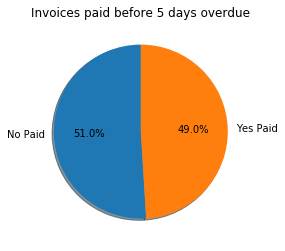

In [35]:
Target = df['Target_True'].value_counts()
fig = plt.figure()

ax = fig.gca()

ax.set_title("Invoices paid before 5 days overdue")

ax.pie(Target,  labels=['No Paid','Yes Paid'], autopct='%1.1f%%',shadow=True,startangle=90)

plt.show()

## Histogram of Days_to_be_paid


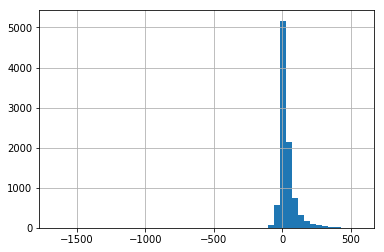

In [36]:
df['Days_tobe_paid'].hist(bins=50)
plt.show()

In [37]:
df=df[df.Days_tobe_paid >-10]

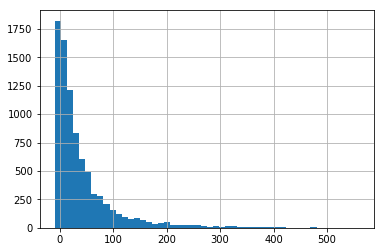

In [38]:
df['Days_tobe_paid'].hist(bins=50)
plt.show()

In [39]:
df.drop( df[df['Days_tobe_paid'] > 300 ].index , inplace=True)

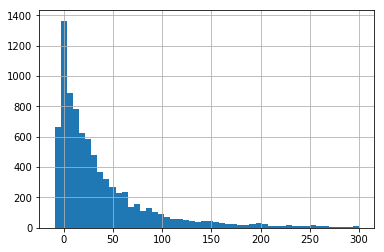

In [40]:
df['Days_tobe_paid'].hist(bins=50)
plt.show()

In [41]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 8347 entries, 11 to 30181
Data columns (total 21 columns):
Document Number                8347 non-null object
Name                           8347 non-null object
Date                           8347 non-null datetime64[ns]
Invoice Sent Date              5259 non-null datetime64[ns]
Due Date                       8347 non-null datetime64[ns]
Payment Date                   8347 non-null datetime64[ns]
Terms                          8308 non-null object
Paying_Transaction             8347 non-null bool
Amount Remaining               8347 non-null float64
Amount                         8347 non-null float64
Days Overdue                   8347 non-null float64
Location                       8347 non-null float64
Date Closed                    8326 non-null datetime64[ns]
Last Collection Notice Sent    2970 non-null object
Days_tobe_paid                 8347 non-null int64
Target_True                    8347 non-null uint8
Days_to_send_inv   

## Scatter plot :  Location vs Days to be paid


Scatter plot to see relation between locations and days taken to bepaid
We se that the line of points continues for those one close to 1.5 points and
is reduced when the client is above 1.5

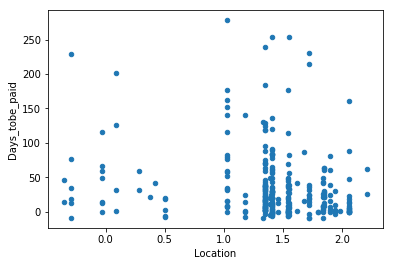

In [43]:
df.sample(n=300).plot.scatter(x='Location', y='Days_tobe_paid', s=None, c=None)
plt.show()

## Has the client short paid or withheld taxes?

I want to see what are the invoice that had payments but they still have open amounts. I am checking whether this
due to withholding taxes or the client short paid.

In [44]:

df['Amount Remaining'].value_counts()

0.000        8326
6715.690        1
112.656         1
3053.530        1
9739.500        1
12146.770       1
1040.200        1
5318.989        1
746.930         1
4353.460        1
2286.180        1
78469.177       1
911.150         1
3462.396        1
7204.303        1
12216.694       1
45766.269       1
2255.461        1
2810.375        1
402.410         1
1133.251        1
60.000          1
Name: Amount Remaining, dtype: int64

In [45]:
df.loc[df['Amount Remaining'] > 0]

,Document Number,Name,Date,Invoice Sent Date,Due Date,Payment Date,Terms,Paying_Transaction,Amount Remaining,Amount,...,Location,Date Closed,Last Collection Notice Sent,Days_tobe_paid,Target_True,Days_to_send_inv,NetTerms,Expected PTP_True,Contingent Due Date_Yes,PO Required_Yes
11,087922,7422,2018-11-20,2018-10-16,2019-01-19,2019-03-15,Net 60,True,78469.177,98646.960,...,1.80,NaT,Portal Lockout,55,0,-35.0,60,0,0,1
23,094522,5251:1,2019-05-01,2019-04-11,2019-06-30,2019-07-17,Net 60,True,45766.269,120443.907,...,1.35,NaT,2nd Past Due Notice,17,0,-20.0,60,0,0,1
71,IND11000362,6369,2019-06-26,2019-07-23,2019-07-26,2019-08-21,Net 30,True,12216.694,144156.953,...,0.09,NaT,NaN,26,0,27.0,30,0,0,1
74,096759,5552,2019-06-02,2019-06-19,2019-07-02,2019-08-26,Net 30,True,12146.770,38462.760,...,-0.03,NaT,2nd Past Due Notice,55,0,17.0,30,0,0,0
90,095871,5552,2019-06-11,2019-05-21,2019-07-11,2019-07-22,Net 30,True,9739.500,64930.000,...,-0.03,NaT,2nd Past Due Notice,11,1,-21.0,30,0,0,0
104,IND11000339,4642,2018-12-15,2018-12-28,2019-02-13,2019-03-08,Net 60,True,7204.303,27432.056,...,0.09,NaT,NaN,23,0,13.0,60,0,0,1
113,096757,5552,2019-06-02,2019-06-19,2019-07-02,2019-08-26,Net 30,True,6715.690,22018.970,...,-0.03,NaT,2nd Past Due Notice,55,0,17.0,30,0,0,0
128,IND11000317,4909,2018-09-26,2018-08-29,2018-10-26,2018-12-18,Net 30,True,5318.989,41924.334,...,0.09,NaT,NaN,53,0,-28.0,30,0,0,0
179,096752,5552,2019-06-02,2019-06-19,2019-07-02,2019-09-05,Net 30,True,4353.460,17413.830,...,-0.03,NaT,2nd Past Due Notice,65,0,17.0,30,0,0,0
186,090998,8463,2018-12-31,2018-12-28,2019-03-01,2019-06-17,Net 60,True,3462.396,18223.136,...,1.03,NaT,NaN,108,0,-3.0,60,0,0,1


In [46]:
df['Rate withheld']=df['Amount Remaining']/df['Amount']

In [47]:
df['Rate withheld'].sort_values(ascending=False)

11       0.795455
23       0.379980
74       0.315806
291      0.314998
113      0.304996
104      0.262624
179      0.250000
269      0.236345
265      0.200966
274      0.199999
260      0.199000
186      0.190000
228      0.151994
90       0.150000
128      0.126871
71       0.084746
216      0.084746
305      0.084743
230      0.050000
192      0.019009
308      0.005027
10487    0.000000
10469    0.000000
10483    0.000000
10482    0.000000
10479    0.000000
10476    0.000000
10470    0.000000
10450    0.000000
10462    0.000000
           ...   
20410    0.000000
20361    0.000000
20363    0.000000
20369    0.000000
20371    0.000000
20378    0.000000
20380    0.000000
20385    0.000000
20387    0.000000
20388    0.000000
20398    0.000000
20404    0.000000
20406    0.000000
20408    0.000000
20417    0.000000
20468    0.000000
20419    0.000000
20421    0.000000
20423    0.000000
20428    0.000000
20432    0.000000
20434    0.000000
20435    0.000000
20439    0.000000
20442    0

We should remove the first one. Probably not the only one that it is not withholding taxes they
are a few and for a low amount.

In [48]:

df=df.drop(11)
df=df.drop(23)

## Scatter plot: Days to be paid vs. Days to send invoice

In [49]:
#df=df.drop(5334)

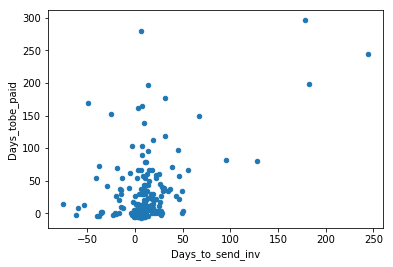

In [50]:
df.sample(n=250).plot.scatter(x='Days_to_send_inv', y='Days_tobe_paid', s=None, c=None)

In [51]:
df.drop( df[df['Days_to_send_inv'] > 50 ].index , inplace=True)
df.drop( df[df['Days_to_send_inv'] < -50 ].index , inplace=True)

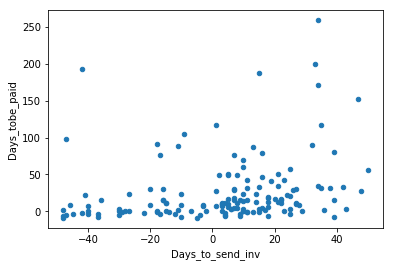

In [52]:
df.sample(n=250).plot.scatter(x='Days_to_send_inv', y='Days_tobe_paid', s=None, c=None)

# New feature: Average of days to pay in the past
## We will create a new feature with average of days to pay invoices in the past.

In [70]:
df['Target_True'].value_counts()

0    4510
1    3511
Name: Target_True, dtype: int64

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8021 entries, 71 to 30181
Data columns (total 22 columns):
Document Number                8021 non-null object
Name                           8021 non-null object
Date                           8021 non-null datetime64[ns]
Invoice Sent Date              4933 non-null datetime64[ns]
Due Date                       8021 non-null datetime64[ns]
Payment Date                   8021 non-null datetime64[ns]
Terms                          7983 non-null object
Paying_Transaction             8021 non-null bool
Amount Remaining               8021 non-null float64
Amount                         8021 non-null float64
Days Overdue                   8021 non-null float64
Location                       8021 non-null float64
Date Closed                    8004 non-null datetime64[ns]
Last Collection Notice Sent    2787 non-null object
Days_tobe_paid                 8021 non-null int64
Target_True                    8021 non-null uint8
Days_to_send_inv   

# Machine Learning: Split data and prepare to model


In [72]:
#Split data

df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)
#df_valid, df_test = train_test_split(df_test, test_size=0.7, random_state=42)

#Define Df_train, df_test, df_valid
#df_train=df_train.loc[:,'Amount':]
#df_train=df_train.drop(['Document Number','Date','Invoice Sent Date','Due Date','Terms','Paying_Transaction','Amount Remaining',
#                        'Days Overdue','Date Closed','Last Collection Notice Sent'],axis=1)

#df_test=df_test.loc[:,'Amount':]
#df_test=df_test.drop(['Document Number','Date','Invoice Sent Date','Due Date','Terms','Paying_Transaction','Amount Remaining',
#                        'Days Overdue','Date Closed','Last Collection Notice Sent'],axis=1)

#df_valid=df_valid.loc[:,'Amount':]
#df_valid=df_valid.drop(['Days Overdue','Days_tobe_paid','Date Closed','Last Collection Notice Sent'],axis=1)

In [73]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5614 entries, 21748 to 27932
Data columns (total 22 columns):
Document Number                5614 non-null object
Name                           5614 non-null object
Date                           5614 non-null datetime64[ns]
Invoice Sent Date              3479 non-null datetime64[ns]
Due Date                       5614 non-null datetime64[ns]
Payment Date                   5614 non-null datetime64[ns]
Terms                          5588 non-null object
Paying_Transaction             5614 non-null bool
Amount Remaining               5614 non-null float64
Amount                         5614 non-null float64
Days Overdue                   5614 non-null float64
Location                       5614 non-null float64
Date Closed                    5601 non-null datetime64[ns]
Last Collection Notice Sent    1947 non-null object
Days_tobe_paid                 5614 non-null int64
Target_True                    5614 non-null uint8
Days_to_send_inv

We are still seeing nun values

In [74]:
df_train=df_train.dropna(subset=['Days_to_send_inv'])
df_test=df_test.dropna(subset=['Days_to_send_inv'])
#df_valid=df_test.dropna(subset=['Days_to_send_inv'])

In [75]:
#No nan
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3479 entries, 21748 to 27932
Data columns (total 22 columns):
Document Number                3479 non-null object
Name                           3479 non-null object
Date                           3479 non-null datetime64[ns]
Invoice Sent Date              3479 non-null datetime64[ns]
Due Date                       3479 non-null datetime64[ns]
Payment Date                   3479 non-null datetime64[ns]
Terms                          3454 non-null object
Paying_Transaction             3479 non-null bool
Amount Remaining               3479 non-null float64
Amount                         3479 non-null float64
Days Overdue                   3479 non-null float64
Location                       3479 non-null float64
Date Closed                    3466 non-null datetime64[ns]
Last Collection Notice Sent    1932 non-null object
Days_tobe_paid                 3479 non-null int64
Target_True                    3479 non-null uint8
Days_to_send_inv

In [76]:
#No nan
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1454 entries, 8428 to 26189
Data columns (total 22 columns):
Document Number                1454 non-null object
Name                           1454 non-null object
Date                           1454 non-null datetime64[ns]
Invoice Sent Date              1454 non-null datetime64[ns]
Due Date                       1454 non-null datetime64[ns]
Payment Date                   1454 non-null datetime64[ns]
Terms                          1442 non-null object
Paying_Transaction             1454 non-null bool
Amount Remaining               1454 non-null float64
Amount                         1454 non-null float64
Days Overdue                   1454 non-null float64
Location                       1454 non-null float64
Date Closed                    1450 non-null datetime64[ns]
Last Collection Notice Sent    836 non-null object
Days_tobe_paid                 1454 non-null int64
Target_True                    1454 non-null uint8
Days_to_send_inv  

In [77]:
df2=df_train.groupby(['Name'])['Days_tobe_paid'].median()

In [78]:
df_train['ave_Days_tobe_paid']=df_train.apply(lambda r: df2.loc[r['Name']],axis=1)

In [79]:
#df_test['ave_Days_tobe_paid']=df_test.apply(lambda r: df2.loc[r['Name']],axis=1)

In [80]:
df_test= pd.merge(df_test,df2,on='Name',how='left')

In [81]:
df_test.rename(columns={"Days_tobe_paid_y": 'ave_Days_tobe_paid'},inplace=True)

In [82]:
df_test.head()

,Document Number,Name,Date,Invoice Sent Date,Due Date,Payment Date,Terms,Paying_Transaction,Amount Remaining,Amount,...,Last Collection Notice Sent,Days_tobe_paid_x,Target_True,Days_to_send_inv,NetTerms,Expected PTP_True,Contingent Due Date_Yes,PO Required_Yes,Rate withheld,ave_Days_tobe_paid
0,066526,5710,2017-03-31,2017-04-07,2017-06-29,2017-12-11,Net 90,True,0.0,32335.892,...,1st Past Due Notice,165,0,7.0,90,0,0,0,0.0,23.0
1,073248,5907,2017-10-22,2017-09-19,2017-11-21,2017-12-27,Net 30,True,0.0,108926.810,...,1st Past Due Notice,36,0,-33.0,30,1,0,0,0.0,74.0
2,090866,7293,2018-12-22,2018-12-21,2019-01-21,2019-02-28,Net 30,True,0.0,21326.017,...,NaN,38,0,-1.0,30,0,0,0,0.0,5.0
3,076810,6617,2017-11-16,2017-12-04,2017-12-31,2018-01-04,Net 45,True,0.0,29359.618,...,NaN,4,1,18.0,45,1,0,0,0.0,2.0
4,095822,7927,2019-06-29,2019-05-23,2019-08-28,2019-08-23,Net 60,True,0.0,234558.909,...,NaN,-5,1,-37.0,60,1,0,1,0.0,56.5


In [83]:
df_train['ave_Days_tobe_paid'].fillna(15, inplace=True)

In [84]:
df_test['ave_Days_tobe_paid'].fillna(15, inplace=True)

In [85]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3479 entries, 21748 to 27932
Data columns (total 23 columns):
Document Number                3479 non-null object
Name                           3479 non-null object
Date                           3479 non-null datetime64[ns]
Invoice Sent Date              3479 non-null datetime64[ns]
Due Date                       3479 non-null datetime64[ns]
Payment Date                   3479 non-null datetime64[ns]
Terms                          3454 non-null object
Paying_Transaction             3479 non-null bool
Amount Remaining               3479 non-null float64
Amount                         3479 non-null float64
Days Overdue                   3479 non-null float64
Location                       3479 non-null float64
Date Closed                    3466 non-null datetime64[ns]
Last Collection Notice Sent    1932 non-null object
Days_tobe_paid                 3479 non-null int64
Target_True                    3479 non-null uint8
Days_to_send_inv

In [86]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1454 entries, 0 to 1453
Data columns (total 23 columns):
Document Number                1454 non-null object
Name                           1454 non-null object
Date                           1454 non-null datetime64[ns]
Invoice Sent Date              1454 non-null datetime64[ns]
Due Date                       1454 non-null datetime64[ns]
Payment Date                   1454 non-null datetime64[ns]
Terms                          1442 non-null object
Paying_Transaction             1454 non-null bool
Amount Remaining               1454 non-null float64
Amount                         1454 non-null float64
Days Overdue                   1454 non-null float64
Location                       1454 non-null float64
Date Closed                    1450 non-null datetime64[ns]
Last Collection Notice Sent    836 non-null object
Days_tobe_paid_x               1454 non-null int64
Target_True                    1454 non-null uint8
Days_to_send_inv      

In [87]:
X_train = df_train.drop(['Name','Days_tobe_paid','Target_True','Payment Date','Document Number',
                         'Date','Invoice Sent Date','Due Date','Terms','Paying_Transaction','Amount Remaining',
                        'Days Overdue','Date Closed','Last Collection Notice Sent'],axis=1)

y_train=df_train['Target_True']

X_test = df_test.drop(['Name','Days_tobe_paid_x','Target_True','Payment Date','Document Number',
                        'Date','Invoice Sent Date','Due Date','Terms','Paying_Transaction','Amount Remaining',
                        'Days Overdue','Date Closed','Last Collection Notice Sent'],axis=1)

y_test=df_test['Target_True']

#X_valid = df_valid.drop('Target_True',axis=1)
#y_valid = df_valid['Target_True']

In [88]:
X_train.shape

(3479, 9)

In [89]:
y_train.value_counts()

0    1855
1    1624
Name: Target_True, dtype: int64

In [90]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3479 entries, 21748 to 27932
Data columns (total 9 columns):
Amount                     3479 non-null float64
Location                   3479 non-null float64
Days_to_send_inv           3479 non-null float64
NetTerms                   3479 non-null int64
Expected PTP_True          3479 non-null uint8
Contingent Due Date_Yes    3479 non-null uint8
PO Required_Yes            3479 non-null uint8
Rate withheld              3479 non-null float64
ave_Days_tobe_paid         3479 non-null float64
dtypes: float64(5), int64(1), uint8(3)
memory usage: 200.5 KB


In [91]:
#I will drop from the model features with contribution less than 1.5% to see if we can get better results
X_train = X_train.drop(columns=['Contingent Due Date_Yes','PO Required_Yes',
                                'Rate withheld', 'Expected PTP_True'])
X_test = X_test.drop(columns=['Contingent Due Date_Yes','PO Required_Yes',
                                'Rate withheld', 'Expected PTP_True',])

In [92]:
#Lets see the importance of each feauture
dt = DecisionTreeClassifier(max_depth=5,
                            min_samples_split=10,
                            min_samples_leaf=10)
dt.fit(X_train, y_train)
pd.Series(dt.feature_importances_,
          index=X_test.columns)

Amount                0.017647
Location              0.009999
Days_to_send_inv      0.067408
NetTerms              0.031155
ave_Days_tobe_paid    0.873791
dtype: float64

In [93]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3479 entries, 21748 to 27932
Data columns (total 5 columns):
Amount                3479 non-null float64
Location              3479 non-null float64
Days_to_send_inv      3479 non-null float64
NetTerms              3479 non-null int64
ave_Days_tobe_paid    3479 non-null float64
dtypes: float64(4), int64(1)
memory usage: 163.1 KB


In [94]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1454 entries, 0 to 1453
Data columns (total 5 columns):
Amount                1454 non-null float64
Location              1454 non-null float64
Days_to_send_inv      1454 non-null float64
NetTerms              1454 non-null int64
ave_Days_tobe_paid    1454 non-null float64
dtypes: float64(4), int64(1)
memory usage: 68.2 KB


# KNN

In [109]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [110]:
knn = KNeighborsClassifier(n_neighbors=5)
scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)


X_test = scaler.transform(X_test)

knn.fit(X_train, y_train)

y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)


In [111]:
print('accuracy=', accuracy_score(y_train, y_train_pred),'\n')
print('accuracy=', accuracy_score(y_test, y_test_pred),'\n')

accuracy= 0.8324231100891061 

accuracy= 0.6746905089408528 



In [112]:
cm = confusion_matrix(y_test, y_test_pred)
pd.DataFrame(cm, 
             index=knn.classes_, 
             columns=knn.classes_)

,0,1
0,533,259
1,214,448


In [113]:
print('\nCross Validation Scores')
scores = cross_val_score(knn, X_train, y_train, 
                         scoring='accuracy',
                         cv=10)

res_dict['KNN']=show_results(scores)


Cross Validation Scores
[0.82808023 0.73352436 0.7277937  0.75644699 0.75574713 0.75792507
 0.74351585 0.70317003 0.76657061 0.74639769]
Mean: 0.7519171649363546
Std: 0.030796729800576555


# SVM

In [114]:
svc = svm.SVC(kernel='rbf', C=1,gamma=0.7).fit(X_train, y_train)
y_train_pred=svc.predict(X_train)
y_test_pred=svc.predict(X_test)


In [115]:
print('\nclassification_report:\n',classification_report(y_train, y_train_pred ))


classification_report:
               precision    recall  f1-score   support

           0       0.83      0.79      0.81      1855
           1       0.78      0.82      0.80      1624

   micro avg       0.81      0.81      0.81      3479
   macro avg       0.81      0.81      0.81      3479
weighted avg       0.81      0.81      0.81      3479



In [116]:
print('accuracy=', accuracy_score(y_train, y_train_pred),'\n')

accuracy= 0.8054038516815176 



In [117]:
print('accuracy=', accuracy_score(y_test, y_test_pred),'\n')

accuracy= 0.6691884456671252 



In [118]:
cm = confusion_matrix(y_test, y_test_pred)
pd.DataFrame(cm, 
             index=svc.classes_, 
             columns=svc.classes_)

,0,1
0,516,276
1,205,457


In [119]:
#def show_results(scores):
#    scores_ = (scores)#**0.5
#    print(scores_)
#    print("Mean:", scores_.mean())
#    print("Std:", scores_.std()) 
#    return scores_.mean()

In [120]:
#res_dict={}

In [121]:
print('\nCross Validation Scores')
scores = cross_val_score(svc, X_train, y_train, 
                         scoring='accuracy',
                         cv=5)

res_dict['SVM']=show_results(scores)


Cross Validation Scores
[0.78735632 0.75574713 0.77155172 0.7658046  0.77697842]
Mean: 0.771487637476226
Std: 0.010602155838110729


In [122]:
#plt.bar(range(len(res_dict)), list(res_dict.values()), align='center')
#plt.xticks(range(len(res_dict)), list(res_dict.keys()))

#plt.title('Cross Validation  results')
#plt.show()

In [123]:
svc.get_params()

{'C': 1,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 0.7,
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

# Random Forest

In [124]:
RandomForestClassifier()


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [125]:
rf = RandomForestClassifier(bootstrap=False,
 class_weight='balanced_subsample',                           
 max_depth= 3,
 max_features= 'auto',
 min_samples_leaf= 4,
 min_samples_split= 10,
 n_estimators= 150)
rf.fit(X_train, y_train)

y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)


In [126]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
res = pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'Threshold': thresholds})
res[['TPR', 'FPR', 'Threshold']]

,TPR,FPR,Threshold
0,0.000000,0.000000,2
1,0.533233,0.238636,1
2,1.000000,1.000000,0


In [127]:
print('accuracy=', accuracy_score(y_train, y_train_pred),'\n')
print('accuracy=', accuracy_score(y_test, y_test_pred),'\n')

accuracy= 0.7875826386892786 

accuracy= 0.657496561210454 



In [128]:
cm = confusion_matrix(y_test, y_test_pred)
pd.DataFrame(cm, 
             index=rf.classes_, 
             columns=rf.classes_)

,0,1
0,603,189
1,309,353


In [129]:
print('\nCross Validation Scores')
scores = cross_val_score(rf, X_train, y_train, 
                         scoring='accuracy',
                         cv=5)

res_dict['RF']=show_results(scores)


Cross Validation Scores
[0.8045977  0.76149425 0.8045977  0.7658046  0.78992806]
Mean: 0.785284462085504
Std: 0.018509481656360596


# eXtreme Gradient Boosting

In [130]:
import xgboost as xgb

In [138]:
xgb_model = xgb.XGBClassifier(max_depth=4,
                                    n_estimators=200,
                                    learning_rate=0.1, 
                                    subsample=0.5,verbose=1)


xgb_model.fit(X_train, y_train, verbose=1)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
       n_estimators=200, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=0.5, verbose=1, verbosity=1)

In [139]:
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

In [140]:
print('accuracy=', accuracy_score(y_train, y_train_pred),'\n')
print('accuracy=', accuracy_score(y_test, y_test_pred),'\n')

accuracy= 0.8476573728082782 

accuracy= 0.6815680880330124 



In [141]:
def classification_results(y, y_pred, name='', classes=['no', 'yes'], add_rep=False):
    acc = accuracy_score(y, y_pred)
                        
    cm = pd.DataFrame(confusion_matrix(y, y_pred), 
                      index=classes, 
                      columns=classes)

    print(name + ' accuracy: ', round(acc,4))
    print()
    print(cm)
    print()
    if (add_rep):
        print(name + ' Classification report: ')
        print(classification_report(y, y_pred))

In [142]:
classification_results(y_train, xgb_model.predict(X_train), name='XGBClassifier train')
classification_results(y_test, xgb_model.predict(X_test), name='XGBClassifier test')

XGBClassifier train accuracy:  0.8477

       no   yes
no   1594   261
yes   269  1355

XGBClassifier test accuracy:  0.6816

      no  yes
no   568  224
yes  239  423



In [144]:
print('\nCross Validation Scores')
scores = cross_val_score(xgb_model, X_train, y_train, 
                         scoring='accuracy',
                         cv=5)

res_dict['XGB']=show_results(scores)


Cross Validation Scores
[0.79454023 0.75574713 0.79741379 0.75574713 0.78561151]
Mean: 0.7778119573306872
Std: 0.01843156871921048
